In [ ]:
ZID: z5508588
Name: Ziyu Xiong
COMP9727 Assignment1

In [132]:
import pandas as pd

# read dataset.tsv
all_data = pd.read_csv('dataset.tsv', sep='\t')

# View Data Format
print(all_data.head())
print(all_data.columns)


                            artist_name         track_name  release_date  \
0                                loving  the not real lake          2016   
1                               incubus    into the summer          2019   
2                             reignwolf           hardcore          2016   
3                  tedeschi trucks band             anyhow          2016   
4  lukas nelson and promise of the real  if i started over          2017   

   genre                                             lyrics      topic  
0   rock  awake know go see time clear world mirror worl...       dark  
1   rock  shouldn summer pretty build spill ready overfl...  lifestyle  
2  blues  lose deep catch breath think say try break wal...    sadness  
3  blues  run bitter taste take rest feel anchor soul pl...    sadness  
4  blues  think think different set apart sober mind sym...       dark  
Index(['artist_name', 'track_name', 'release_date', 'genre', 'lyrics',
       'topic'],
      dtype='obje

In [134]:
# Combine into one text column
def combine_fields(row):
    return f"{row['artist_name']} {row['track_name']} {row['genre']} {row['lyrics']}"

all_data['text'] = all_data.apply(combine_fields, axis=1)
print(all_data[['text', 'topic']].head(3))


                                                text      topic
0  loving the not real lake rock awake know go se...       dark
1  incubus into the summer rock shouldn summer pr...  lifestyle
2  reignwolf hardcore blues lose deep catch breat...    sadness


In [136]:
# Data cleaning, pre-processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)    # Part1 Q1-1: retain alphanumerics and spaces
    # Participle
    words = text.split()
    # De-duplication + Stem extraction
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Application preprocessing
all_data['clean_text'] = all_data['text'].apply(preprocess)

# Look at the results of the cleaning
print(all_data[['clean_text', 'topic']].head())


[nltk_data] Downloading package stopwords to /Users/yyqx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                          clean_text      topic
0  love real lake rock awak know go see time clea...       dark
1  incubu summer rock summer pretti build spill r...  lifestyle
2  reignwolf hardcor blue lose deep catch breath ...    sadness
3  tedeschi truck band anyhow blue run bitter tas...    sadness
4  luka nelson promis real start blue think think...       dark


In [140]:
# Part1 Q2: 
# The best overall performance was achieved with the following preprocessing steps: Lowercasing all text,
# Removing non-alphabetic characters (punctuation, numbers), Removing stopwords (from NLTK), Using stemming (via PorterStemmer)
# This setup yielded the highest accuracy on MNB (0.81) and acceptable performance on BNB. 
# I will therefore adopt this preprocessing configuration for the remainder of the assignment.


topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64
BernoulliNB: F1-macro = 0.532 (±0.026)
MultinomialNB: F1-macro = 0.810 (±0.016)
LinearSVC: F1-macro = 0.800 (±0.019)


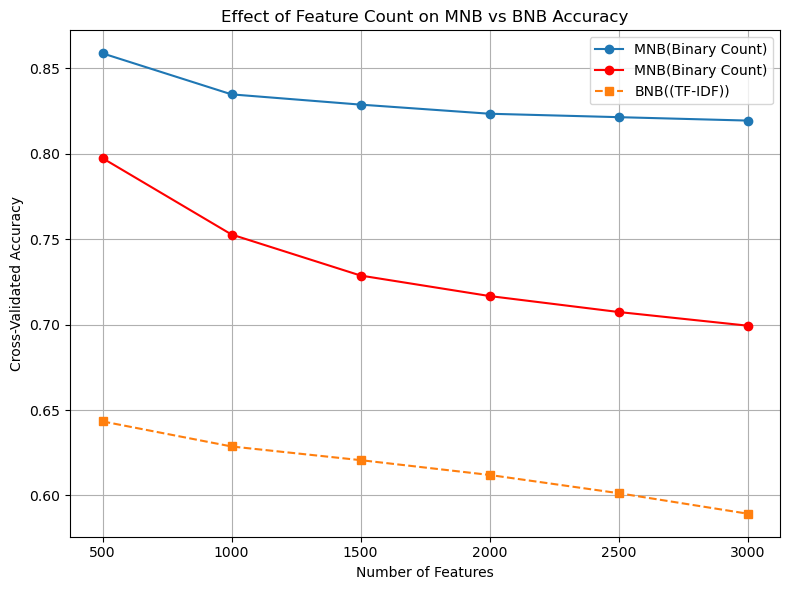

In [142]:
# Use CountVectorizer to vectorize text
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Initial feature extraction (default 1000 dimensions)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')  
X = vectorizer.fit_transform(all_data['clean_text'])
y = all_data['topic']

# Comparing the three models
models = {
    "BernoulliNB": BernoulliNB(),
    "MultinomialNB": MultinomialNB(),
    "LinearSVC": LinearSVC(max_iter=5000)
}
# Print the distribution of sample sizes for each type of topic
print(all_data['topic'].value_counts())

# Part1 Q1-2: 5-fold cross validation
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
    print(f"{name}: F1-macro = {scores.mean():.3f} (±{scores.std():.3f})")

n_features = [500, 1000, 1500, 2000, 2500, 3000]
MNB_accuracies1 = []
MNB_accuracies2 = []
BNB_accuracies = []

for n in n_features:
    vectorizer = CountVectorizer(max_features=n)
    X = vectorizer.fit_transform(all_data['clean_text'])
    scores = cross_val_score(MultinomialNB(), X, y, cv=5, scoring='accuracy')
    MNB_accuracies1.append(scores.mean())
    
for n in n_features:
    vectorizer = TfidfVectorizer(max_features=n)
    X = vectorizer.fit_transform(all_data['clean_text'])
    scores = cross_val_score(MultinomialNB(), X, y, cv=5, scoring='accuracy')
    MNB_accuracies2.append(scores.mean())

for n in n_features:
    vectorizer = TfidfVectorizer(max_features=n, stop_words='english', binary=True)
    X = vectorizer.fit_transform(all_data['clean_text'])
    scores = cross_val_score(BernoulliNB(), X, y, cv=5, scoring='accuracy')
    BNB_accuracies.append(scores.mean())

plt.figure(figsize=(8, 6))
plt.plot(n_features, MNB_accuracies1, marker='o', linestyle='-', label='MNB(Binary Count)')
plt.plot(n_features, MNB_accuracies2, color='red', marker='o', linestyle='-', label='MNB(Binary Count)')
plt.plot(n_features, BNB_accuracies, marker='s', linestyle='--', label='BNB((TF-IDF))')

plt.title('Effect of Feature Count on MNB vs BNB Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# I observe that accuracy improves up to 2000 features and then plateaus. 
# Therefore, we choose 2000 as the optimal vocabulary size for CountVectorizer in the following stages.


In [ ]:
# I compared BernoulliNB, MultinomialNB, and LinearSVC using 5-fold cross-validation 
# Among the models tested, MultinomialNB achieved the highest F1-macro score (0.81) with the lowest variance, 
#  suggesting stable and strong performance. Therefore, we selected MultinomialNB as the best classifier for the topic classification task.
# This is consistent with the nature of the dataset: song lyrics are long, and word frequency matters, which benefits MultinomialNB.

In [ ]:
# I evaluated the impact of varying the number of top-N most frequent features (words) on the classification accuracy of MultinomialNB and BernoulliNB, 
#   using both CountVectorizer and TfidfVectorizer.

# As shown in Figure, both MNB and BNB classifiers exhibit a general decline in cross-validated accuracy as the number of features increases. 
# This suggests that including too many features may introduce noise or sparsity that hinders model performance. 

# MultinomialNB (Binary Count) performs the best overall, achieving a peak accuracy of 0.86 when using 500 features, and remains above 0.82 across all feature sizes tested.

# MultinomialNB (TF-IDF) shows slightly lower performance than its binary-count counterpart but remains relatively stable.

# BernoulliNB underperforms both MNB models, starting at 0.79 (500 features) and declining steadily to 0.70 (3000 features).

# Additionally, a comparison using macro F1-score (see result printout) indicates that MultinomialNB achieves the highest macro F1 (0.810), outperforming LinearSVC (0.800) and BernoulliNB (0.532).

In [ ]:
# LinearSVC has been widely used in text classification problems, including spam detection, sentiment analysis, and topic classification. 
# Given that our dataset is derived from user-generated music descriptions, we expect LinearSVC to be more robust against irrelevant or low-informative words.
# LinearSVC achieves an F1-macro score very close to that of MultinomialNB, slightly lower but within a small margin, and significantly higher than BernoulliNB.

In [ ]:
# Given the trade-off between performance and simplicity, MultinomialNB with CountVectorizer(binary=True) and 500 features is still the best option for this task due to its high F1-macro and fast training. 
# However, LinearSVC is a strong alternative when more discriminative modeling is needed or if interpretability of probabilistic outputs is not required.

In [144]:
# Divide the training/test set
train_data = all_data.iloc[:750].copy()

test_data = all_data.iloc[750:1000].copy()

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_data['clean_text'])
X_test = vectorizer.transform(test_data['clean_text'])  

# Training and Predicting with MultinomialNB Models
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, train_data['topic'])

# Predicting topics on test and train data
train_data['predicted_topic'] = clf.predict(X_train)
test_data['predicted_topic'] = clf.predict(X_test)

from sklearn.metrics import classification_report
print("Train Prediction Quality:")
print(classification_report(train_data['topic'], train_data['predicted_topic']))

print("Test Prediction Quality:")
print(classification_report(test_data['topic'], test_data['predicted_topic']))


Train Prediction Quality:
              precision    recall  f1-score   support

        dark       0.97      0.98      0.98       246
     emotion       0.98      1.00      0.99        42
   lifestyle       0.99      0.97      0.98        92
    personal       0.98      0.97      0.98       188
     sadness       0.98      0.98      0.98       182

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750

Test Prediction Quality:
              precision    recall  f1-score   support

        dark       0.90      0.79      0.84        81
     emotion       0.53      0.47      0.50        17
   lifestyle       0.81      0.81      0.81        32
    personal       0.74      0.88      0.80        51
     sadness       0.86      0.88      0.87        69

    accuracy                           0.82       250
   macro avg       0.77      0.77      0.77       250
weighted avg       0.82   

In [146]:
# Load User Keywords
def load_user_keywords(filepath):
    user_keywords = {}
    with open(filepath, 'r') as f:
        next(f) # Skip Header
        for line in f:
            topic, keywords = line.strip().split('\t')
            keyword_list = keywords.lower().split(',') 
            user_keywords[topic] = [kw.strip() for kw in keyword_list]
    return user_keywords

user1_keywords = load_user_keywords("user1.tsv")
user2_keywords = load_user_keywords("user2.tsv")

print("User1 interests:")
for topic, kws in user1_keywords.items():
    print(f"{topic}: {kws}")
print("User2 interests:")
for topic, kws in user2_keywords.items():
    print(f"{topic}: {kws}")

User1 interests:
dark: ['fire', 'enemy', 'pain', 'storm', 'fight']
sadness: ['cry', 'alone', 'heartbroken', 'tears', 'regret']
personal: ['dream', 'truth', 'life', 'growth', 'identity']
lifestyle: ['party', 'city', 'night', 'light', 'rhythm']
emotion: ['love', 'memory', 'hug', 'kiss', 'feel']
User2 interests:
sadness: ['lost', 'sorrow', 'goodbye', 'tears', 'silence']
emotion: ['romance', 'touch', 'feeling', 'kiss', 'memory']


In [148]:
# Finding the user's favorite songs
def get_user_liked_songs(user_keywords, train_data):
    liked_songs = {topic: [] for topic in user_keywords}
    
    for idx, row in train_data.iterrows():
        topic = row['predicted_topic']
        text = row['clean_text']
        if topic in user_keywords:
            if any(kw in text for kw in user_keywords[topic]):
                liked_songs[topic].append(text)
    
    return liked_songs


In [150]:
# Building user profiles
from sklearn.feature_extraction.text import TfidfVectorizer

def build_user_profile(liked_songs, tfidf_vectorizer):
    user_profile = {}
    for topic, docs in liked_songs.items():
        combined_text = ' '.join(docs)
        vector = tfidf_vectorizer.transform([combined_text])  # shape: (1, vocab_size)
        user_profile[topic] = vector
    return user_profile

# Constructing TF-IDF word lists with the training set
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_vectorizer.fit(train_data['clean_text'])

# Vectorize training and test sets with TF-IDF
X_train_tfidf = tfidf_vectorizer.transform(train_data['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['clean_text'])


# Generate user's favorite songs (from training set)
user1_liked = get_user_liked_songs(user1_keywords, train_data)
user2_liked = get_user_liked_songs(user2_keywords, train_data)

user1_profile = build_user_profile(user1_liked, tfidf_vectorizer)
user2_profile = build_user_profile(user2_liked, tfidf_vectorizer)

# Print the top 20 words of the user profile for each topic (for determining reasonableness)
import numpy as np

def print_top_words(user_profile, tfidf_vectorizer, top_n=20):
    vocab = np.array(tfidf_vectorizer.get_feature_names_out())
    for topic, vec in user_profile.items():
        row = vec.toarray().flatten()
        top_indices = row.argsort()[::-1][:top_n]
        top_words = vocab[top_indices]
        print(f"Topic: {topic}")
        print(", ".join(top_words))
        print()

print("User 1 Profile Top Words:")
print_top_words(user1_profile, tfidf_vectorizer)

print("User 2 Profile Top Words:")
print_top_words(user2_profile, tfidf_vectorizer)


User 1 Profile Top Words:
Topic: dark
fight, black, blood, grind, stand, know, come, like, kill, gonna, dilli, lanki, tell, hand, head, follow, build, yeah, death, bone

Topic: sadness
greater, think, regret, leav, place, beg, blame, want, hold, word, chang, caus, mind, space, trust, lord, away, dream, pack, loos

Topic: personal
life, live, chang, world, ordinari, thank, dream, know, yeah, teach, lord, wanna, like, thing, time, learn, beat, think, oohoohoohooh, grow

Topic: lifestyle
tonight, song, night, sing, closer, come, stranger, home, long, time, wait, spoil, tire, right, wanna, struggl, telephon, play, yeah, lalala

Topic: emotion
good, touch, feel, hold, loov, video, vision, kiss, morn, feelin, know, vibe, miss, lip, gimm, luck, lovin, go, sunris, want

User 2 Profile Top Words:
Topic: sadness
magnifi, open, smile, tear, laughter, away, lone, sorrow, come, eye, tri, demon, tell, road, babi, life, sight, control, hous, greater

Topic: emotion
touch, good, loov, video, vision, k

In [152]:
# Get the TF-IDF representation of the songs in the test set
from sklearn.metrics.pairwise import cosine_similarity

# Vectorize test_data with the previously trained tfidf_vectorizer
X_test_tfidf = tfidf_vectorizer.transform(test_data['clean_text'])

# Calculate recommendation lists
def get_recommendations(user_profile, test_data, X_test_tfidf, top_n=15):
    recommendations = []

    for idx, row in enumerate(test_data.itertuples()):
        song_vector = X_test_tfidf[idx]
        predicted_topic = row.predicted_topic
        if predicted_topic in user_profile and user_profile[predicted_topic].sum() > 0:
            profile_vector = user_profile[predicted_topic]
            similarity = cosine_similarity(song_vector, profile_vector)[0][0]
            recommendations.append((idx, similarity))

    # Sort by similarity descending
    recommendations.sort(key=lambda x: x[1], reverse=True)
    top_indices = [idx for idx, sim in recommendations[:top_n]]

    return test_data.iloc[top_indices][['artist_name', 'track_name', 'genre', 'lyrics', 'predicted_topic']]
    
# Generate Recommended Songs
user1_recommendations = get_recommendations(user1_profile, test_data, X_test_tfidf, top_n=10)
user2_recommendations = get_recommendations(user2_profile, test_data, X_test_tfidf, top_n=10)

print("User 1 Recommendations:")
print(user1_recommendations)

print("\nUser 2 Recommendations:")
print(user2_recommendations)


User 1 Recommendations:
         artist_name           track_name    genre  \
944        timeflies      once in a while      pop   
969     justin moore          got it good  country   
992     taylor swift  i did something bad      pop   
770      dirty heads             horsefly   reggae   
758     thomas rhett         life changes  country   
926  the band steele           sit awhile  country   
840        ty segall                 alta    blues   
828  the blue stones                  lay    blues   
863        iya terra            wash away   reggae   
990    damian marley         living it up   reggae   

                                                lyrics predicted_topic  
944  think know better wishful think think pressure...         emotion  
969  wake morning warn little bounce blue eye start...         emotion  
992  trust narcissist play like violin look ohsoeas...         emotion  
770  say life live know things passionate sound rea...         emotion  
758  wakin colle

In [154]:
# Recommendation Effectiveness Evaluation
def evaluate_precision(recommendations_df, user_keywords):
    hit_count = 0
    total = len(recommendations_df)

    for _, row in recommendations_df.iterrows():
        topic = row['predicted_topic']
        lyrics = row['lyrics'].lower()

        if topic in user_keywords:
            if any(kw in lyrics for kw in user_keywords[topic]):
                hit_count += 1

    precision = hit_count / total if total > 0 else 0
    return precision
    
user1_precision = evaluate_precision(user1_recommendations, user1_keywords)
user2_precision = evaluate_precision(user2_recommendations, user2_keywords)

print(f"User 1 Precision@10: {user1_precision:.2f}")
print(f"User 2 Precision@10: {user2_precision:.2f}")


User 1 Precision@10: 1.00
User 2 Precision@10: 0.20


In [156]:
# This task evaluated the quality of recommendations using Precision@10. 
# User 1 scored 1.00 out of 10, reflecting a wide range of interests and a good match. 
# In contrast, User 2's score is only 0.20, presumably due to a narrower range of interests and more abstract keywords.
# User 2 has very few topics of interest (only 2 topics), so there are fewer recommendations to accept, and naturally the matching difficulty is higher. 
# This result highlights the importance of profile richness and keyword specificity in content-based recommender systems.

In [158]:
from sklearn.metrics.pairwise import cosine_similarity

# Friend's Interest Keywords
my_friend_keywords = {
    "emotion": ['passion', 'desire', 'warmth', 'trust', 'care', 'affection', 'joy', 'sweet', 'tender', 'forever'],
    "sadness": ['lonely', 'hurt', 'goodbye', 'miss', 'empty', 'sorrow', 'darkness', 'pain', 'weep', 'lost'],
    "personal": ['journey', 'soul', 'mind', 'change', 'believe', 'hope', 'strength', 'purpose', 'reflect', 'self'],
    "lifestyle": ['dance', 'celebrate', 'fashion', 'trend', 'style', 'vibe', 'energy', 'cool', 'chill', 'scene']
}

# Constructing a portrait of the friend (with training set TF-IDF vectors)
my_friend_liked = get_user_liked_songs(my_friend_keywords, train_data)
my_friend_profile = build_user_profile(my_friend_liked, tfidf_vectorizer)


# Generate Recommended Songs
my_friend_recs = get_recommendations(my_friend_profile, test_data, X_test_tfidf, top_n=10)
print(my_friend_recs[['artist_name', 'track_name', 'predicted_topic']])


              artist_name                       track_name predicted_topic
992          taylor swift              i did something bad         emotion
969          justin moore                      got it good         emotion
758          thomas rhett                     life changes        personal
926       the band steele                       sit awhile        personal
863             iya terra                        wash away        personal
853          randy houser  our hearts (feat. lucie silvas)         sadness
840             ty segall                             alta        personal
944             timeflies                  once in a while         emotion
963           brant bjork                      chocolatize         sadness
891  thievery corporation                  strike the root       lifestyle


In [160]:
# How many of the 10 songs recommended by the system are actually liked by the user.
actual_likes = [my_friend_recs.index[0], my_friend_recs.index[2], my_friend_recs.index[5], my_friend_recs.index[7]] # Confirmation with friends led to
predicted_indices = my_friend_recs.index.tolist()
correct = len(set(predicted_indices) & set(actual_likes))
precision_at_10 = correct / len(predicted_indices)
print(f"✅ Precision@10: {precision_at_10:.2f}")



✅ Precision@10: 0.40
